In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
df = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)
df.drop('article_link', axis='columns', inplace=True)
df

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
26704,american politics in moral free-fall,0
26705,america's best 20 hikes,0
26706,reparations and obama,0
26707,israeli ban targeting boycott supporters raise...,0


In [24]:
df['headline'] = df['headline'].astype(str)
df['is_sarcastic'] = df['is_sarcastic'].astype(int)

x_train, x_test, y_train, y_test = train_test_split(df['headline'], df['is_sarcastic'], test_size=0.2, random_state=4)

In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # 2 labels: Not sarcastic, Sarcastic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
def encode_sentences(sentences):
    return tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

In [27]:
inputs_train = encode_sentences(x_train.tolist())
inputs_test = encode_sentences(x_test.tolist())
labels_train = torch.tensor(y_train.tolist())
labels_test = torch.tensor(y_test.tolist())


In [28]:
# tunning
batchNum=16
learningRate=5e-5
Epoch=5

In [29]:
# Create a dataset and data loader
train_dataset = TensorDataset(inputs_train['input_ids'], inputs_train['attention_mask'], labels_train)
test_dataset = TensorDataset(inputs_test['input_ids'], inputs_test['attention_mask'], labels_test)
train_loader = DataLoader(train_dataset, batch_size=batchNum, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchNum)

optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

In [30]:
model.train()
train_losses = []
train_accuracies = []

for epoch in range(Epoch):  # number of epochs
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    print(f"------- Epoch: {epoch+1} -------")
    for batch in tqdm(train_loader):
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predictions = torch.argmax(outputs.logits, dim=1)
        correct_preds += (predictions == labels).sum().item()
        total_preds += labels.size(0)

    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = correct_preds / total_preds
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f"Loss: {epoch_loss}, Accuracy: {epoch_accuracy}")

------- Epoch: 1 -------


100%|██████████| 1336/1336 [1:59:58<00:00,  5.39s/it] 


Loss: 0.26285490725178295, Accuracy: 0.8883792764543454
------- Epoch: 2 -------


100%|██████████| 1336/1336 [1:58:59<00:00,  5.34s/it]


Loss: 0.10638567479022341, Accuracy: 0.9627462910095006
------- Epoch: 3 -------


100%|██████████| 1336/1336 [1:58:35<00:00,  5.33s/it]


Loss: 0.047495579255302504, Accuracy: 0.9843216174474657
------- Epoch: 4 -------


100%|██████████| 1336/1336 [1:58:58<00:00,  5.34s/it]


Loss: 0.03420522051511033, Accuracy: 0.988346515654982
------- Epoch: 5 -------


100%|██████████| 1336/1336 [2:04:00<00:00,  5.57s/it] 

Loss: 0.024133897006028426, Accuracy: 0.991762999017176


In [31]:
import numpy as np
train_loss_model4 = np.array(train_losses)
train_accuracies_model4 = np.array(train_accuracies)
loss_df = pd.DataFrame(train_loss_model4)
acc_df = pd.DataFrame(train_accuracies)
loss_df.to_csv("train_loss_model4.csv")
acc_df.to_csv("train_accuracies_model4.csv")

# Save the model
model.save_pretrained('./sarcasm-detection-model4')
# model = BertForSequenceClassification.from_pretrained('./sarcasm-detection-model4')

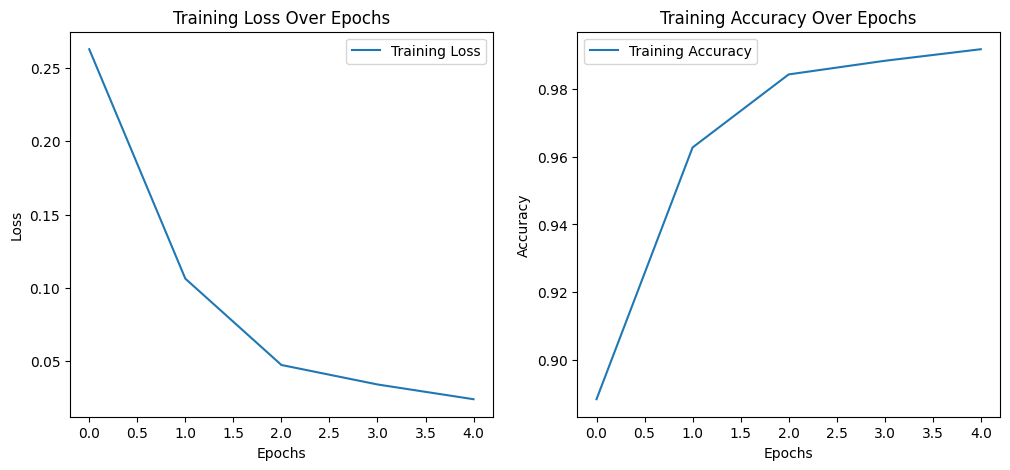

In [32]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [33]:
# model = BertForSequenceClassification.from_pretrained('./sarcasm-detection-model4')

In [34]:
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(labels.tolist())

In [41]:
# Calculate accuracy and other metrics
import numpy as np
testing_labels_final = np.array(true_labels)
pred_label = np.array(predictions)
print(classification_report(testing_labels_final, pred_label, target_names=['Not Sarcastic', 'Sarcastic']))

accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1_score:.4f}")

               precision    recall  f1-score   support

Not Sarcastic       0.96      0.91      0.93      3062
    Sarcastic       0.89      0.94      0.91      2280

     accuracy                           0.93      5342
    macro avg       0.92      0.93      0.92      5342
 weighted avg       0.93      0.93      0.93      5342



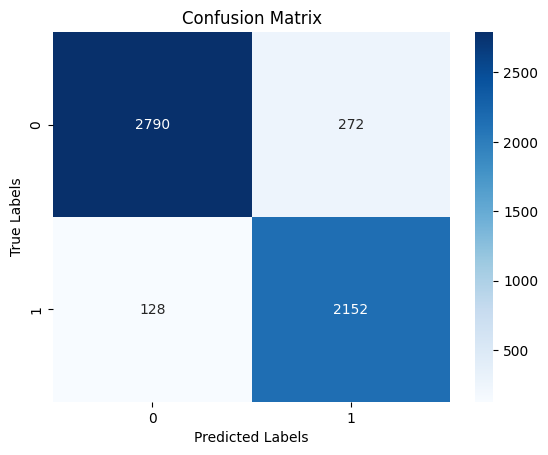

In [36]:
# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()